# 0. Introduction 

# I. Dépendances

In [70]:
#Importation des bibliothèques nécessaires au preprocessing
#et à l'entraînement des deux modèles finaux choisis

import pandas as pd
import numpy as np
from random import sample
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.svm import SVC
from sklearn import ensemble
import lightgbm as lgb
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

import joblib

# II. Import des données

In [71]:
SEED = 42

In [72]:
# Chargement du jeu de données
fraud_df = pd.read_csv('https://assets-datascientest.s3-eu-west-1.amazonaws.com/de/total/fraud.csv',
                       parse_dates = ['signup_time','purchase_time'])

# III. Description et recherche des valeurs manquantes

In [73]:
# Infos sur chaque colonne
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  is_fraud        151112 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB


In [74]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [75]:
fraud_df.isna().sum()

#Aucune donnée ne comporte des valeurs nulles

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
is_fraud          0
dtype: int64

In [76]:
# Nombre de valeurs uniques par colonne
fraud_df.nunique()

#Les user_id sont tous uniques
#Il sera inutile d'éviter les doublons lors de la séparation du jeu de données entre entraînement et test

user_id           151112
signup_time       151112
purchase_time     150679
purchase_value       122
device_id         137956
source                 3
browser                5
sex                    2
age                   58
ip_address        143511
is_fraud               2
dtype: int64

In [77]:
# Proportion de fraudes dans le jeu de données, le jeu de données est déséquilibré
print(fraud_df.is_fraud.value_counts())
print(fraud_df.is_fraud.value_counts(normalize=True))

0    136961
1     14151
Name: is_fraud, dtype: int64
0    0.906354
1    0.093646
Name: is_fraud, dtype: float64


# IV. Data Viz

In [78]:
# Création de colonnes de temps afin de mieux visualiser des patterns dans le jeu de données
fraud = fraud_df.copy()
fraud["purchase_date"] = fraud.purchase_time.dt.date
fraud["purchase_hour"] = fraud.purchase_time.dt.hour
fraud["purchase_weekday"] = fraud.purchase_time.dt.weekday
fraud["purchase_month"] = fraud.purchase_time.dt.month
fraud["purchase_day"] = fraud.purchase_time.dt.day
fraud["signup_date"] = fraud.signup_time.dt.date
fraud["days_till_signup"] = fraud.purchase_date - fraud.signup_date
fraud.days_till_signup = fraud.days_till_signup.dt.days
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud,purchase_date,purchase_hour,purchase_weekday,purchase_month,purchase_day,signup_date,days_till_signup
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,2015-04-18,2,5,4,18,2015-02-24,53
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,2015-06-08,1,0,6,8,2015-06-07,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,2015-01-01,18,3,1,1,2015-01-01,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,2015-05-04,13,0,5,4,2015-04-28,6
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,2015-09-09,18,2,9,9,2015-07-21,50


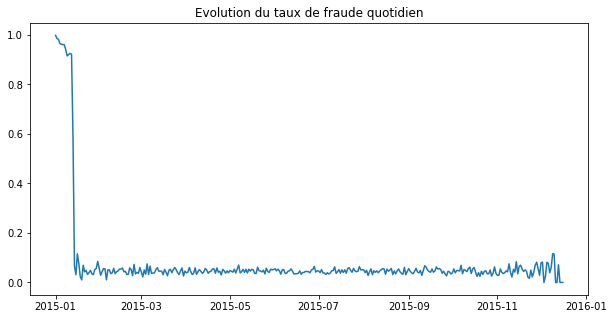

In [79]:
plt.figure(figsize=(10,5))
plt.plot(fraud[["purchase_date", "is_fraud"]].groupby(["purchase_date"]).mean());
plt.title("Evolution du taux de fraude quotidien");
#On remarque que le jeu de données présente comme une "cassure" au mois de janvier
#Le taux de fraude passe de 100% à 5%

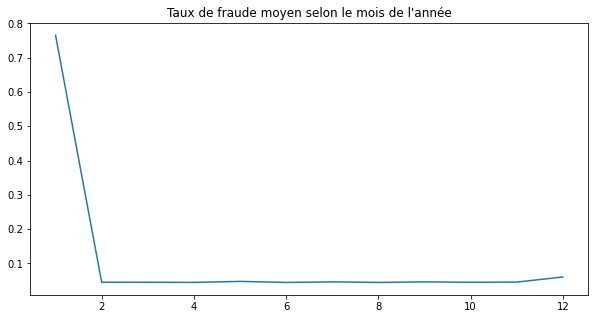

In [80]:
plt.figure(figsize=(10,5))
plt.plot(fraud[["purchase_month", "is_fraud"]].groupby(["purchase_month"]).mean());
plt.title("Taux de fraude moyen selon le mois de l'année");

#Exception faite du mois de janvier, on constate uniquement une légère augmentation en décembre

Text(0.5, 1.0, 'Taux de fraude moyen selon le jour de la semaine')

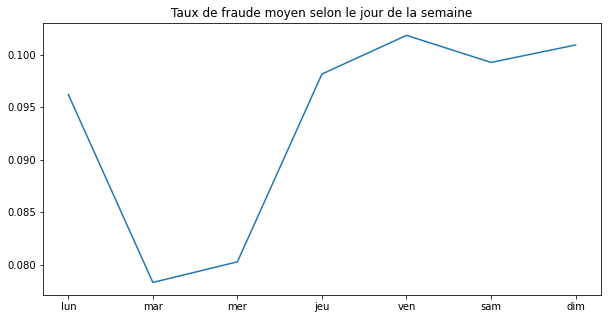

In [81]:
plt.figure(figsize=(10,5))
plt.plot(["lun", "mar", "mer", "jeu", "ven", "sam", "dim"], 
         fraud[["purchase_weekday", "is_fraud"]].groupby(["purchase_weekday"]).mean()["is_fraud"]);
plt.title("Taux de fraude moyen selon le jour de la semaine")

#Il ne semble pas y avoir une grosse influence du jour de la semaine sur le taux de fraude

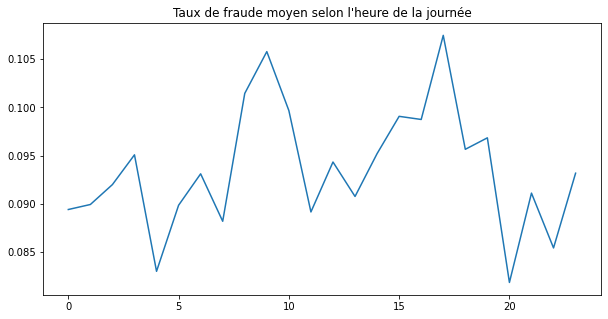

In [82]:
plt.figure(figsize=(10,5))
plt.plot(fraud[["purchase_hour", "is_fraud"]].groupby(["purchase_hour"]).mean());
plt.title("Taux de fraude moyen selon l'heure de la journée");

#Même constat pour l'heure

/Users/francois/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_fraud', ylabel='count'>

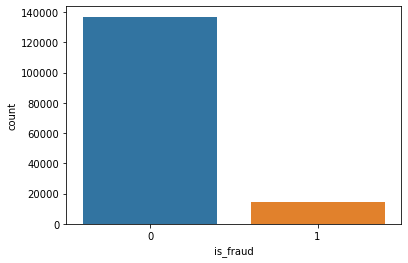

In [83]:
target = fraud["is_fraud"]
sns.countplot(target)

#Le déséquilibre des données apparaît clairement, 
#nous allons employer des techniques visant à ré-équilibrer l'écart afin de ne pas avoir de biais dans nos prédictions

# V. Data Preprocessing

## V.1. Preprocessing pour le premier modèle

In [84]:
# Choix des variables quantitatives
data = fraud[["days_till_signup", "purchase_month", "purchase_day", "purchase_weekday", 
              "purchase_hour", "purchase_value", "age"]]

In [85]:
# Choix et encodage des variables catégorielles
data = data.join(pd.get_dummies(fraud[["source", "browser"]], drop_first=True))
data = data.join(fraud.sex.replace(["M", "F"], [0,1]))

In [86]:
data.head()

,days_till_signup,purchase_month,purchase_day,purchase_weekday,purchase_hour,purchase_value,age,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex
0,53,4,18,5,2,34,39,0,1,0,0,0,0,0
1,1,6,8,0,1,16,53,0,0,0,0,0,0,1
2,0,1,1,3,18,15,53,0,1,0,0,1,0,0
3,6,5,4,0,13,44,41,0,1,0,0,0,1,0
4,50,9,9,2,18,39,45,0,0,0,0,0,1,0


In [87]:
# Définition de la variable cible
target = fraud.is_fraud

## V.2. Preprocessing pour le second modèle

In [89]:
def process_df(original_df):
    df = original_df.copy()
    df = df.drop(columns=['device_id','source','browser',
                             'sex','ip_address'])
    df['delay_signup_purchase'] = (df['signup_time'] - df['purchase_time']).dt.seconds
    for col_prefix in ['signup', 'purchase']:
        df[f'{col_prefix}_year'] = df[f'{col_prefix}_time'].dt.year
        df[f'{col_prefix}_month'] = df[f'{col_prefix}_time'].dt.month
        df[f'{col_prefix}_weekday'] = df[f'{col_prefix}_time'].dt.weekday
        df[f'cos_{col_prefix}_month'] = np.cos(2.*np.pi*df[f'{col_prefix}_month']/12.)
        df[f'sin_{col_prefix}_month'] = np.sin(2.*np.pi*df[f'{col_prefix}_month']/12.)
        df[f'{col_prefix}_hour'] = df[f'{col_prefix}_time'].dt.hour
        df[f'cos_{col_prefix}_hour'] = np.cos(2.*np.pi*df[f'{col_prefix}_hour']/24.)
        df[f'sin_{col_prefix}_hour'] = np.sin(2.*np.pi*df[f'{col_prefix}_hour']/24.)
        df[f'{col_prefix}_minute'] = df[f'{col_prefix}_time'].dt.minute
        df[f'cos_{col_prefix}_minute'] = np.cos(2.*np.pi*df[f'{col_prefix}_minute']/60.)
        df[f'sin_{col_prefix}_minute'] = np.sin(2.*np.pi*df[f'{col_prefix}_minute']/60.)
        df[f'{col_prefix}_int_value'] = df[f'{col_prefix}_time'].apply(lambda x: x.value)
        df = df.drop(columns=[f'{col_prefix}_time'])
    return df

In [90]:
processed_balanced_fraud_df = process_df(fraud_df)

In [91]:
processed_balanced_fraud_df.head()

,user_id,purchase_value,age,is_fraud,delay_signup_purchase,signup_year,signup_month,signup_weekday,cos_signup_month,sin_signup_month,...,purchase_weekday,cos_purchase_month,sin_purchase_month,purchase_hour,cos_purchase_hour,sin_purchase_hour,purchase_minute,cos_purchase_minute,sin_purchase_minute,purchase_int_value
0,22058,34,39,0,72518,2015,2,1,0.500000,8.660254e-01,...,5,-5.000000e-01,8.660254e-01,2,8.660254e-01,0.500000,47,0.207912,-0.978148,1429325231000000000
1,333320,16,53,0,68456,2015,6,6,-1.000000,1.224647e-16,...,0,-1.000000e+00,1.224647e-16,1,9.659258e-01,0.258819,38,-0.669131,-0.743145,1433727534000000000
2,1359,15,53,1,86399,2015,1,3,0.866025,5.000000e-01,...,3,8.660254e-01,5.000000e-01,18,-1.836970e-16,-1.000000,52,0.669131,-0.743145,1420138365000000000
3,150084,44,41,0,26315,2015,4,1,-0.500000,8.660254e-01,...,0,-8.660254e-01,5.000000e-01,13,-9.659258e-01,-0.258819,54,0.809017,-0.587785,1430747690000000000
4,221365,39,45,0,44939,2015,7,1,-0.866025,-5.000000e-01,...,2,-1.836970e-16,-1.000000e+00,18,-1.836970e-16,-1.000000,40,-0.500000,-0.866025,1441824053000000000


# VI. Modélisation

## VI.1. Modélisation avec RandomForestClassifier

In [59]:
# Séparation en jeu d'entrainement et de test.
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=50)

In [60]:
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [61]:
from sklearn import ensemble
clf = ensemble.RandomForestClassifier(random_state=321)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=321)

In [62]:
y_pred = clf.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=["réelles"], colnames=["prédites"])

prédites,0,1
réelles,,
0,41022,9
1,1964,2339


In [63]:
clf.score(X_test, y_test)

0.9564785811973353

In [64]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      1.00      0.54      0.98      0.74      0.57     41031
          1       1.00      0.54      1.00      0.70      0.74      0.52      4303

avg / total       0.96      0.96      0.59      0.95      0.74      0.56     45334



In [ ]:
#Fonction pour reproduction du preprocessing plus tard dans l'API

def process_first_model(original_df):
    df = original_df.copy()
    df["purchase_date"] = df.purchase_time.dt.date
    df["purchase_hour"] = df.purchase_time.dt.hour
    df["purchase_weekday"] = df.purchase_time.dt.weekday
    df["purchase_month"] = df.purchase_time.dt.month
    df["purchase_day"] = df.purchase_time.dt.day
    df["signup_date"] = df.signup_time.dt.date
    df["days_till_signup"] = df.purchase_date - df.signup_date
    df.days_till_signup = df.days_till_signup.dt.days
    df = df[["days_till_signup", "purchase_month", "purchase_day", "purchase_weekday", 
              "purchase_hour", "purchase_value", "age"]]
    df = df.join(pd.get_dummies(original_df[["source", "browser"]], drop_first=True))
    df = df.join(original_df.sex.replace(["M", "F"], [0,1]))
    
    return df

## VI.2. Modélisation avec lightgbm et oversampling

In [92]:
x_df_unb = processed_balanced_fraud_df.loc[:, processed_balanced_fraud_df.columns != 'is_fraud'].reset_index(drop=True)
y_df_unb = processed_balanced_fraud_df[['is_fraud']]
ros = RandomOverSampler(random_state=SEED)
x_df, y_df = ros.fit_resample(x_df_unb, y_df_unb)

In [93]:
x_df.head(3)

,user_id,purchase_value,age,delay_signup_purchase,signup_year,signup_month,signup_weekday,cos_signup_month,sin_signup_month,signup_hour,...,purchase_weekday,cos_purchase_month,sin_purchase_month,purchase_hour,cos_purchase_hour,sin_purchase_hour,purchase_minute,cos_purchase_minute,sin_purchase_minute,purchase_int_value
0,22058,34,39,72518,2015,2,1,0.500000,8.660254e-01,22,...,5,-0.500000,8.660254e-01,2,8.660254e-01,0.500000,47,0.207912,-0.978148,1429325231000000000
1,333320,16,53,68456,2015,6,6,-1.000000,1.224647e-16,20,...,0,-1.000000,1.224647e-16,1,9.659258e-01,0.258819,38,-0.669131,-0.743145,1433727534000000000
2,1359,15,53,86399,2015,1,3,0.866025,5.000000e-01,18,...,3,0.866025,5.000000e-01,18,-1.836970e-16,-1.000000,52,0.669131,-0.743145,1420138365000000000


In [94]:
gs = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=SEED)

In [95]:
train_indexes, test_indexes = next(gs.split(x_df, y_df, groups=x_df.user_id))

x_train = x_df.iloc[train_indexes]
y_train = y_df.iloc[train_indexes]

x_test = x_df.iloc[test_indexes]
y_test = y_df.iloc[test_indexes]

x_train = x_train.drop(columns=['user_id'])
x_test = x_test.drop(columns=['user_id'])

In [96]:
#Entraînement avec recherche par validation croisée afin d'obtenir un modèle optimisé
#qui servira à extraire les features les plus importantes avec RFE
clf = lgb.LGBMClassifier()

#Liste des paramètres et de leurs valeurs possibles
param_dist = { 'max_depth':[2, 4, 6],  
               'min_child_weight':[0.001, 0.01, 0.1, 1, 2],
               'subsample':np.arange(0.75, 0.90, 0.01),
               'colsample_bytree': np.arange(0.80, 1, 0.1), 
               'reg_alpha':[.001, .005, .0005],
               'reg_lambda':[.001, .005, .0005],
                    }

grid = RandomizedSearchCV(clf, param_dist, verbose=1, cv=5, n_jobs = -1, n_iter=10)
grid.fit(x_train, y_train.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.8, 0.9]),
                                        'max_depth': [2, 4, 6],
                                        'min_child_weight': [0.001, 0.01, 0.1,
                                                             1, 2],
                                        'reg_alpha': [0.001, 0.005, 0.0005],
                                        'reg_lambda': [0.001, 0.005, 0.0005],
                                        'subsample': array([0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85,
       0.86, 0.87, 0.88, 0.89, 0.9 ])},
                   verbose=1)

In [97]:
optimized_model = lgb.LGBMClassifier(**grid.best_params_)

#Ce modèle optimisé va servir de base à la sélection des features

In [98]:
#Sélection des variables à partir du modèle obtenu précédemment
selector = RFE(optimized_model, step=1)
selector = selector.fit(x_train, y_train.values.ravel())

In [99]:
cols_to_keep = x_train.loc[:, selector.support_].columns
cols_to_keep

Index(['purchase_value', 'age', 'delay_signup_purchase', 'signup_hour',
       'signup_minute', 'cos_signup_minute', 'sin_signup_minute',
       'signup_int_value', 'purchase_hour', 'sin_purchase_hour',
       'purchase_minute', 'cos_purchase_minute', 'purchase_int_value'],
      dtype='object')

In [100]:
#On ré-entraîne le modèle uniquement avec les features issues de la sélection RFE

more_optimized_model = lgb.LGBMClassifier(**grid.best_params_)
more_optimized_model.fit(x_train[cols_to_keep], y_train.values.ravel())

LGBMClassifier(colsample_bytree=0.9, max_depth=6, min_child_weight=0.01,
               reg_alpha=0.005, reg_lambda=0.001, subsample=0.8800000000000001)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

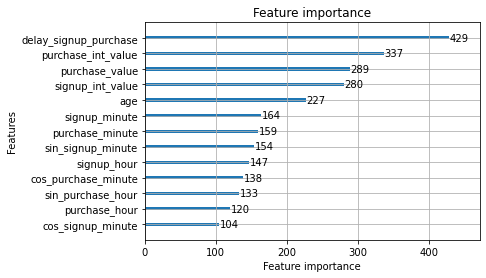

In [101]:
#Identification de l'importance des variables 

lgb.plot_importance(more_optimized_model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

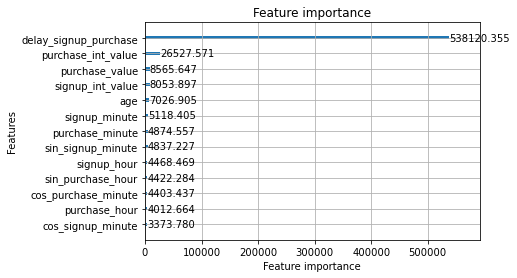

In [102]:
lgb.plot_importance(more_optimized_model, importance_type="gain")

In [ ]:
#Le temps écoulé entre la souscription et la transaction est la feature la plus importante
#Vient ensuite la valeur de la transaction

In [103]:
#Maintenant que nous connaissons les features les plus importantes,
#nous allons faire une nouvelle modélisation en modifiant les hyperparamètres uniquement avec ces features
clf = lgb.LGBMClassifier()

param_dist = { 'max_depth':[2, 4, 6],  
               'min_child_weight':[0.001, 0.01, 0.1, 1, 2],
               'subsample':np.arange(0.75, 0.90, 0.01),
               'colsample_bytree': np.arange(0.80, 1, 0.1), 
               'reg_alpha':[.001, .005, .0005],
               'reg_lambda':[.001, .005, .0005],
                    }

grid = RandomizedSearchCV(clf, param_dist, verbose=1, cv=5, n_jobs = -1, n_iter=10)
grid.fit(x_train[cols_to_keep], y_train.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.8, 0.9]),
                                        'max_depth': [2, 4, 6],
                                        'min_child_weight': [0.001, 0.01, 0.1,
                                                             1, 2],
                                        'reg_alpha': [0.001, 0.005, 0.0005],
                                        'reg_lambda': [0.001, 0.005, 0.0005],
                                        'subsample': array([0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85,
       0.86, 0.87, 0.88, 0.89, 0.9 ])},
                   verbose=1)

In [104]:
best_optimized_model = lgb.LGBMClassifier(**grid.best_params_)
best_optimized_model.fit(x_train[cols_to_keep], y_train.values.ravel())

LGBMClassifier(colsample_bytree=0.9, max_depth=6, min_child_weight=0.01,
               reg_alpha=0.005, reg_lambda=0.005, subsample=0.8800000000000001)

In [105]:
#Tests sur les données de test
y_pred = best_optimized_model.predict(x_test[cols_to_keep])

f1_score(y_test.values.ravel(), y_pred)

0.7067557535263549

In [106]:
recall_score(y_test.values.ravel(), y_pred)

0.5469496211713167

In [107]:
precision_score(y_test.values.ravel(), y_pred)

0.9984922976073418

In [108]:
confusion_matrix(y_test.values.ravel(), y_pred)

array([[27323,    23],
       [12617, 15232]])

In [109]:
#Fonction pour reproduction du preprocessing plus tard dans l'API

def process_second_model(original_df):
    df = original_df.copy()
    df['delay_signup_purchase'] = (df['signup_time'] - df['purchase_time']).dt.seconds
    for col_prefix in ['signup', 'purchase']:
        df[f'{col_prefix}_year'] = df[f'{col_prefix}_time'].dt.year
        df[f'{col_prefix}_month'] = df[f'{col_prefix}_time'].dt.month
        df[f'{col_prefix}_weekday'] = df[f'{col_prefix}_time'].dt.weekday
        df[f'cos_{col_prefix}_month'] = np.cos(2.*np.pi*df[f'{col_prefix}_month']/12.)
        df[f'sin_{col_prefix}_month'] = np.sin(2.*np.pi*df[f'{col_prefix}_month']/12.)
        df[f'{col_prefix}_hour'] = df[f'{col_prefix}_time'].dt.hour
        df[f'cos_{col_prefix}_hour'] = np.cos(2.*np.pi*df[f'{col_prefix}_hour']/24.)
        df[f'sin_{col_prefix}_hour'] = np.sin(2.*np.pi*df[f'{col_prefix}_hour']/24.)
        df[f'{col_prefix}_minute'] = df[f'{col_prefix}_time'].dt.minute
        df[f'cos_{col_prefix}_minute'] = np.cos(2.*np.pi*df[f'{col_prefix}_minute']/60.)
        df[f'sin_{col_prefix}_minute'] = np.sin(2.*np.pi*df[f'{col_prefix}_minute']/60.)
        df[f'{col_prefix}_int_value'] = df[f'{col_prefix}_time'].apply(lambda x: x.value)
        df = df.drop(columns=[f'{col_prefix}_time'])
    df = df[['purchase_value', 'age', 'delay_signup_purchase', 'signup_hour',
           'signup_minute', 'cos_signup_minute', 'sin_signup_minute',
           'signup_int_value', 'purchase_hour', 'sin_purchase_hour',
           'purchase_minute', 'cos_purchase_minute', 'purchase_int_value']]
    return df

# VII. Sauvegarde des modèles entraînés pour utilisation ultérieure

## VII.1. Premier modèle 

In [111]:
joblib.dump(clf, 'fraud_rfc.pkl')
rfc_pickle = joblib.load('fraud_rfc.pkl')

## VII.2. Deuxième modèle

In [110]:
joblib.dump(best_optimized_model, 'fraud_lgb.pkl')
gbm_pickle = joblib.load('fraud_lgb.pkl')